In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
import math
from scipy.stats import t

# Data Pre-Processing

Netmat matricies Data file: **Data/HCP/HCP_PTN1200/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz**

- 1003 subjects
- For time series (4800 total timepoints)

In [2]:
hcp_file = 'Data/netmats_3T_HCP1200_MSMAll_ICAd100_ts2.tar.gz'

In [3]:
# Read Network Matricies
data_raw = []

with gzip.open(hcp_file, 'rb') as gz_file:
    with tarfile.open(fileobj=gz_file, mode='r') as tar:
        
        # Extract a text file
        for file in tar.getnames():
            if file.endswith('.txt'):
                # Read the content and load it into a NumPy array
                subjects = np.loadtxt(tar.extractfile(file), dtype=float)
                
                ICAd = int(np.sqrt(subjects.shape[1]))
                
                # Convert into matrix
                matrix = np.array([np.reshape(i, (ICAd, ICAd)) for i in subjects])
                data_raw.append(matrix)

In [4]:
data_raw[0].shape

(1003, 100, 100)

In [5]:
data_raw[1].shape

(1003, 100, 100)

1. netmats1: Using "full" normalized temporal correlation between every node timeseries and every other. This is a common approach and is
very simple, but it has various practical and interpretational disadvantages [Smith 2012].

In [6]:
net_mat1 = data_raw[0]
net_mat1[0]

array([[ 0.     , -1.5323 , 35.936  , ...,  0.80711,  4.5279 ,  4.9836 ],
       [-1.5323 ,  0.     , -9.1569 , ...,  0.52657,  3.277  ,  1.7371 ],
       [35.936  , -9.1569 ,  0.     , ..., -0.67059,  0.22134, -0.87813],
       ...,
       [ 0.80711,  0.52657, -0.67059, ...,  0.     ,  1.2762 ,  3.6853 ],
       [ 4.5279 ,  3.277  ,  0.22134, ...,  1.2762 ,  0.     ,  4.497  ],
       [ 4.9836 ,  1.7371 , -0.87813, ...,  3.6853 ,  4.497  ,  0.     ]])

2. netmats2: Using partial temporal correlation between nodes' timeseries. This aims to estimate direct connection strengths better than
achieved by full correlation. To slightly improve the estimates of partial correlation coefficients, a small amount of L2 regularization is
applied (setting rho=0.01 in the Ridge Regression netmats option in FSLNets) [Smith OHBM 2014, FSLNets].

In [7]:
net_mat2 = data_raw[1]
net_mat2[0]

array([[ 0.     ,  0.61676,  9.5727 , ...,  0.38609, -0.18148,  2.4279 ],
       [ 0.61676,  0.     ,  2.856  , ..., -0.7748 , -0.43767, -1.0479 ],
       [ 9.5727 ,  2.856  ,  0.     , ...,  0.34688, -0.34526, -1.2173 ],
       ...,
       [ 0.38609, -0.7748 ,  0.34688, ...,  0.     , -0.30947,  3.0171 ],
       [-0.18148, -0.43767, -0.34526, ..., -0.30947,  0.     ,  0.26007],
       [ 2.4279 , -1.0479 , -1.2173 , ...,  3.0171 ,  0.26007,  0.     ]])

In [8]:
id_file = 'Data/IDs/subjectIDs.txt'
id_recon1_file = 'Data/IDs/subjectIDs_recon1.txt'
id_recon2_file = 'Data/IDs/subjectIDs_recon2.txt'

In [9]:
# Read Subject IDs
subject_IDs = np.loadtxt(id_file, dtype=int)

In [10]:
subject_IDs.shape

(1003,)

In [11]:
# Read Subject Descriptions
subject_data = pd.read_csv('Data/subjects.csv', index_col = 'Subject')

In [12]:
subject_data.head()

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [13]:
subject_data = subject_data[['Gender', 'Age']]
subject_data.head()

,Gender,Age
Subject,,
100004,M,22-25
100206,M,26-30
100307,F,26-30
100408,M,31-35
100610,M,26-30


In [14]:
net_mat2[0]

array([[ 0.     ,  0.61676,  9.5727 , ...,  0.38609, -0.18148,  2.4279 ],
       [ 0.61676,  0.     ,  2.856  , ..., -0.7748 , -0.43767, -1.0479 ],
       [ 9.5727 ,  2.856  ,  0.     , ...,  0.34688, -0.34526, -1.2173 ],
       ...,
       [ 0.38609, -0.7748 ,  0.34688, ...,  0.     , -0.30947,  3.0171 ],
       [-0.18148, -0.43767, -0.34526, ..., -0.30947,  0.     ,  0.26007],
       [ 2.4279 , -1.0479 , -1.2173 , ...,  3.0171 ,  0.26007,  0.     ]])

In [15]:
# Combine the netmats and id data in data frame
net_mat_data = pd.Series(dict(zip(subject_IDs, net_mat2))).to_frame().rename(columns = {0 : 'netmat'})
net_mat_data

,netmat
100206,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."
...,...
992673,"[[0.0, -0.11536, 7.1338, -5.5322, 0.34004, 1.6..."
992774,"[[0.0, 0.25353, 8.0265, -6.2072, 4.1589, 1.582..."
993675,"[[0.0, -1.0378, 10.709, -3.3224, -0.090704, 2...."
994273,"[[0.0, 0.64613, 11.471, -5.5137, 1.9357, 4.259..."


In [16]:
# Now merge the two lists
data = subject_data.join(net_mat_data, how = 'right')

In [17]:
data.head()

,Gender,Age,netmat
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


In [18]:
data.shape

(1003, 3)

_________

# EDA

## Hypothesis Testing  
Here, we will perform statistical tests to compare the pairwise correlation matrices of male and female subjects.

## helper functions

In [19]:
def get_tstats(group1, group2, col_name, diff_means_mat): 
    """
    Finds t-statistics for a two-sample t-test given the difference of means between
    group 1 and group 2 (assumes unequal variances).

    * note that this is for testing many hypotheses simultaneously.
    
    args:
        group 1 (pd.DataFrame)       - pandas DataFrame containing the sample values from group 1
        group 2 (pd.DataFrame)       - pandas DataFrame containing the sample values from group 2
        variable (str)               - name of column in which sample values are stored
        diff_means_mat (2D np.array) - square symmetric ixj matrix containing difference of 
                                        means between group 1 and group 2.

    returns:
        t_stats (2D np.array) - square symmetric ixj matrix containing the t-statistic 
                                for the given difference of means at [i, j].
        g1_sqse (float)       - squared standard error of group 1
        g2_sqse (float)       - squared standard error of group 2
    """
    # generate a matrix to store the t-statistics
    rows, cols = diff_means_mat.shape
    t_stats = np.zeros((rows, cols))

    # get the indices of each pairwise correlation
    # u_row_ix, u_col_ix = np.triu_indices(n=rows, k=1) # k=1 excludes diagonal values
    u_row_ix, u_col_ix = np.triu_indices(n=3, k=1) # k=1 excludes diagonal values

    # calculate the t-statistic for each pairwise correlation value 
    # STEP 1: Calculate the estimated overall standard error for both groups  
    def get_squared_se(group_df):
        group_netmats = np.stack(group_df[col_name].to_numpy())
        n = len(group_netmats) # sample size
        ss = lambda netmats : np.sum((netmats - np.mean(netmats, axis=0))**2, axis=0) # sum of squared difference from the mean
        var = lambda netmats: ss(netmats) / (n - 1) # variance 
        return var(group_netmats) / n
    
    g1_sqse = get_squared_se(group1) # Group 1 squared standard error
    g2_sqse = get_squared_se(group2) # Group 2 squared standard error
    
    overall_se = np.sqrt(g1_sqse + g2_sqse) # Estimated overall standard error

    # STEP 2: Calculate the t-statistic
    t_stats = diff_means_mat / overall_se

    t_stats[np.isnan(t_stats)] = 0 # set diagonal to 0

    return t_stats, [g1_sqse, g2_sqse]

In [20]:
def get_sig_regions(regions, p_values, alpha, title="Statistically Signficant Pairwise Correlations Between Males and Females"):    
    significant_regions = np.where(p_values < alpha, regions, 0)

    values_sd = np.std(significant_regions)
    values_mean = np.round(np.mean(significant_regions))

    vmax = values_mean + 3 * values_sd # capture 99.7 percent of the dataset, values more than 3 sd from mean casted to extreme colors
    vmin = values_mean - 3 * values_sd

    plotting.plot_matrix(
        significant_regions, colorbar=True, vmax=vmax, vmin=vmin, title=title)
    
    return significant_regions

## Step 1. Find observed difference in male and female subjects

In [21]:
# load in data
# fp = "Data/data_clean.csv"

sex = "Gender" # column name for male or female assignment
netmat = "netmat"

df = data[[sex, netmat]]

m = "M"
f = "F"
male_df = df[df[sex] == m] # get all males
female_df = df[df[sex] == f] # get all females

avg_netmat = df.groupby(sex).mean()[netmat] # find element-wise averages in male correlation matrix and female correlation matrix
m_avg_netmat = avg_netmat.loc[m]
f_avg_netmat = avg_netmat.loc[f]

diff_avg_netmat = m_avg_netmat - f_avg_netmat # find element-wise difference in averages between male and female correlation matrix (M - F)

## Aggregated Pairwise Correlation Matrices

In [22]:
num_males = male_df.shape[0]
num_females = female_df.shape[0]
print(f"Below are the correlation matrices found by performing element-wise averages on each unique pairwise correlation value \nfor all {num_males} males, and again for all {num_females} females.")

Below are the correlation matrices found by performing element-wise averages on each unique pairwise correlation value 
for all 469 males, and again for all 534 females.


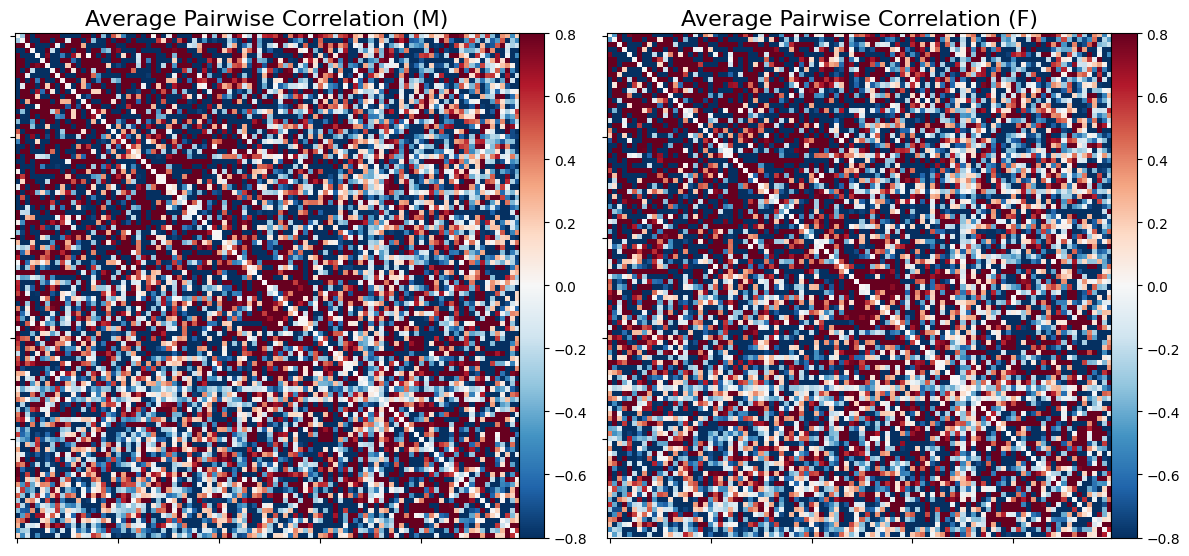

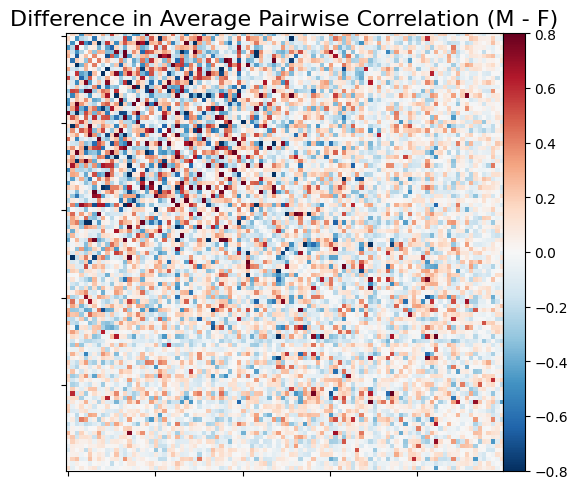

In [23]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plotting.plot_matrix( # visualize element-wise average of males
    m_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, axes=axes[0], title = "Average Pairwise Correlation (M)")


plotting.plot_matrix( # visualize element-wise average of females
    f_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, axes=axes[1], title = "Average Pairwise Correlation (F)")


plotting.plot_matrix( # visualize element-wise difference of averages
    diff_avg_netmat, colorbar=True, vmax=0.8, vmin=-0.8, title = "Difference in Average Pairwise Correlation (M - F)")

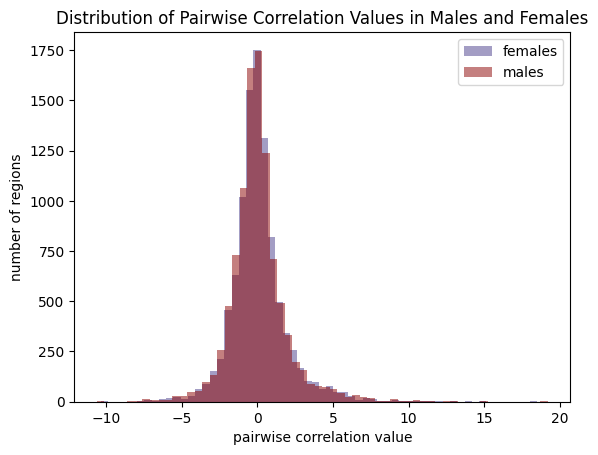

In [24]:
bins = 60
plt.hist(m_avg_netmat.flatten(), bins=bins, label="females", alpha=0.5, color="darkslateblue")
plt.hist(f_avg_netmat.flatten(), bins=bins, label="males", alpha=0.5, color="darkred")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Pairwise Correlation Values in Males and Females')
plt.legend()

plt.show()

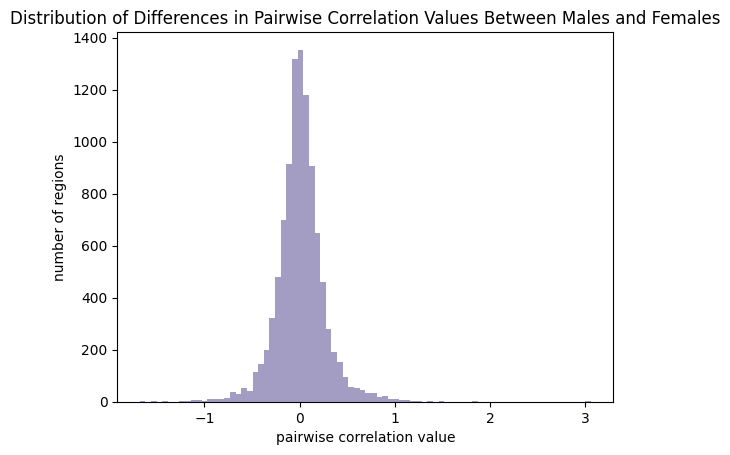

In [25]:
bins = 80
plt.hist(diff_avg_netmat.flatten(), bins=bins, alpha=0.5, color="darkslateblue")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Differences in Pairwise Correlation Values Between Males and Females')

plt.show()

In [26]:
# "overall" difference
observed_overall_diff = np.linalg.norm(diff_avg_netmat)
observed_overall_diff

25.708548144957906

We are interested in whether there is a difference in male and female fMRI resting state data. In order to test this difference, we compare the pairwise correlation matrices of roughly 500 male subject and 500 female subjects. We aggregated the male subjects' and the female subjects' pairwise correlation matrices into a single matrix that contains the average correlation for each of the unique pairwise regions.  
  
To further explore the possible differences in male and female fMRI resting state data, we represented the averaged correlation matrices for each sex as a histogram and found that, to the naked eye, there are no visually obvious differences between male and female fMRI resting state data.  
  
However, we can conduct a more formal test that better quantifies whether the observed difference between male and female data is statistically significant.

## Step 2. Perform Statistical Tests

## I. Conducting an A/B Test

### A. Simulate Under Null Hypothesis

Here, we conduct an A/B test that quantifies whether the observed difference between male and female data is statistically significant.  
  
To conduct an A/B test, we begin by defining a Null Hypothesis and Alternative Hypothesis:  
- Null Hypothesis ($H_0$): Male and female fMRI resting state data are not different.
    - Male and female correlation matrices come from the same distribution.
- Alternative Hypothesis ($H$): Male and female fMRI resting state data are different.
    - Male and female correlation matrices do not come from the same distribution

In [50]:
df = df.reset_index(drop=False).rename(columns={'index':'id'})

In [51]:
num_shuffles = 500 # arbitrarily large number of trials
differences = [0] * num_shuffles # difference between male and female correlation matrix for each trial
overall_differences = [0] * num_shuffles # norm of difference matrix

np.random.seed(1234)
for i in range(num_shuffles):
    
    # STEP 1: Shuffle the sex
    shuffled_sex = (
        df[sex]
        .sample(frac=1)
        .reset_index(drop=True) 
    )
    
    # STEP 2: Put them in a DataFrame
    shuffled = (
        df
        .assign(shuffled_sex=shuffled_sex)
    )
    
    # STEP 3: Compute the test statistic
    group_means = (
        shuffled
        .groupby('shuffled_sex')[netmat]
        .mean()
    )
    difference = group_means.loc[m] - group_means.loc[f] # find difference of each average pairwise correlation in males and females
    
    # STEP 4: Store the result
    differences[i] = difference
    overall_differences[i] = np.linalg.norm(difference)
    

### B. Calculate p-values

Here, we conduct an A/B test that quantifies whether the observed difference between male and female data is statistically significant.  
  
To conduct an A/B test, we begin by defining a Null Hypothesis and Alternative Hypothesis:  
- Null Hypothesis ($H_0$): Male and female fMRI resting state data are not different.
    - Male and female correlation matrices come from the same distribution.
- Alternative Hypothesis ($H$): Male and female fMRI resting state data are different.
    - Male and female correlation matrices do not come from the same distribution

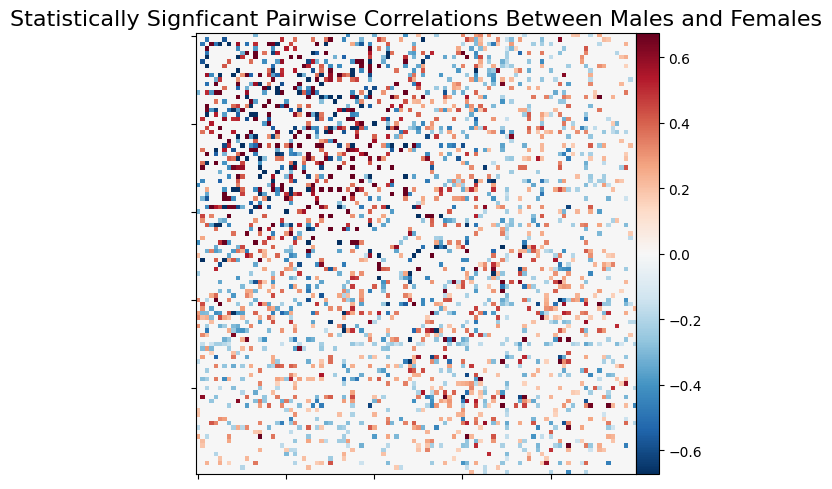

In [52]:
alpha = 0.01 

num_regions = diff_avg_netmat.shape[0]
num_pairwise_regions = math.comb(num_regions, 2)
num_pairwise_regions # total number of hypotheses
bonferroni_alpha = alpha / num_pairwise_regions # bonferroni correction

p_vals = np.mean((np.array(np.abs(differences)) >= np.abs(diff_avg_netmat)), axis=0) # proportion of differences greater than observed difference for each pairwise region

significant_regions = get_sig_regions(diff_avg_netmat, p_vals, bonferroni_alpha)

In [30]:
# p-value with overall difference
(overall_differences > np.abs(observed_overall_diff)).mean()

0.0

### C. Check Error Rate

In [31]:
fp = [0] * len(differences)
bonferroni_fp = [0] * len(differences)

for null_idx in range(len(differences)):
    null_diff_avg_netmat = differences[null_idx]
    mask = np.arange(len(differences)) != null_idx
    null_differences = np.array(differences)[mask]

    # error rate under alpha=0.01
    p_vals = np.mean((np.array(np.abs(null_differences)) >= np.abs(null_diff_avg_netmat)), axis=0) # proportion of differences greater than observed difference for each pairwise region
    fp[null_idx] = (p_vals < alpha).mean()

    # error rate under bonferroni-corrected alpha=0.01/4950
    bonferroni_fp[null_idx] = (p_vals < bonferroni_alpha).mean()

print(f"There is a {np.mean(fp)} error rate with a significance level of 0.01 (alpha={alpha}).")
print(f"There is a {np.mean(bonferroni_fp)} error rate with the bonferroni-corrected significance level (alpha={bonferroni_alpha}).")

There is a 0.009899999999999999 error rate with a significance level of 0.01 (alpha=0.01).
There is a 0.00198 error rate with the bonferroni-corrected significance level (alpha=2.02020202020202e-06).


## II. Conducting a Two-Sample $t$-Test

### A. Check Assumptions

Here, we must check a few assumptions about our data before conducting a two-sample t-test.   
*note that we are using Welch's t-test, which does not assume that the two populations have the same variance**

1. Populations are independent of one another.
    - We know that male pairwise correlation matrices are independent from female pairwise correlation matrices.  
2. Populations are normally distributed.
    - The Fischer Transform of correlation values produces gaussian distributions for each pairwise region across all subjects in the respective sex.  
3. Data within each population are independent.
    - We know that the correlation matrices of same-sex subjects are independent from eahcother.
    

In [32]:
## Assumption 2 : is there a better way to prove this?
# male_netmats = np.stack(male_df[netmat].to_numpy())
# female_netmats = np.stack(female_df[netmat].to_numpy())

# i = 0
# j = 4
# m_region_ij = male_netmats[:, i, j]

# plt.hist(m_region_ij, bins=30)

### B. Perform t-test

Here, we conduct an two-sample t-test that quantifies whether the observed difference between male and female fMRI data is statistically significant.  
  
To conduct an two-sample t-test, we begin by defining a Null Hypothesis and Alternative Hypothesis:  
- Null Hypothesis ($H_0$): Male and female fMRI resting state data are not different.
    - The average correlation matrix of all males and the average correlation matrix of all females have a difference of 0.
    - $\mu_{Male} - \mu_{Female} = 0$
- Alternative Hypothesis ($H$): Male and female fMRI resting state data are different.
    - The average correlation matrix of all males and the average correlation matrix of all females do not have a difference of 0.
    - $\mu_{Male} - \mu_{Female} \neq 0$


In [33]:
def get_upper_triangular(symmetric_matrix):
    '''returns only the upper triangular values of a symmetric matrix'''
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1
    return symmetric_matrix[np.triu_indices(n=num_pairwise, k=no_diagonal)]

In [34]:
t_stats, m_f_sqse = get_tstats(male_df, female_df, netmat, diff_avg_netmat)

C:\Users\dfabe\AppData\Local\Temp\ipykernel_34828\884613704.py:44: RuntimeWarning: invalid value encountered in divide
  t_stats = diff_means_mat / overall_se


### C. Calculate P-values

In [35]:
dof = data.shape[0] - 2 # total number of males and females (1003)
t_p_vals = t.sf(np.abs(t_stats), dof) * 2 # two-sided t-test

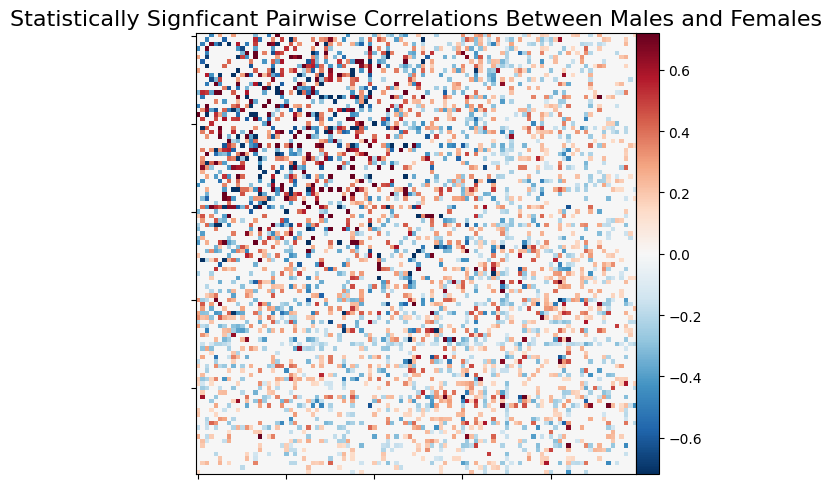

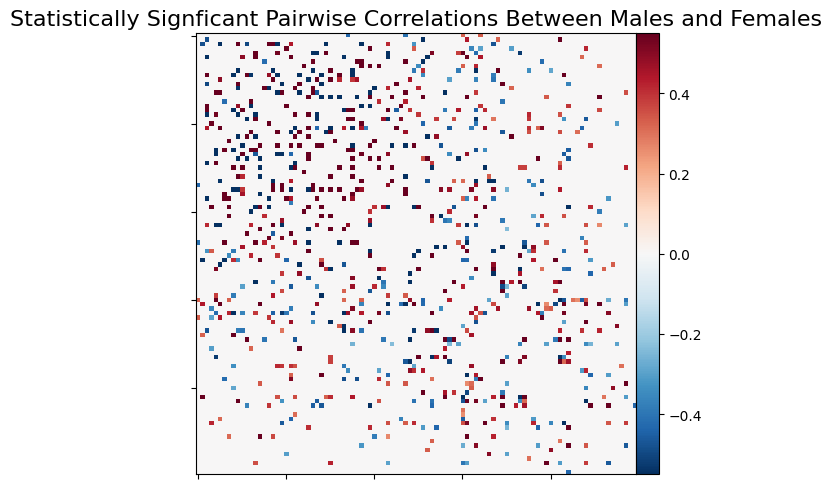

In [36]:
alpha = 0.01

num_regions = diff_avg_netmat.shape[0]
num_pairwise_regions = math.comb(num_regions, 2)
bonferroni_alpha = alpha / num_pairwise_regions # bonferroni correction

t_significant_regions = get_sig_regions(diff_avg_netmat, t_p_vals, alpha)
t_significant_regions_bonferroni = get_sig_regions(diff_avg_netmat, t_p_vals, bonferroni_alpha)

In [37]:
(t_p_vals < bonferroni_alpha).sum() / 2

427.0

## IV. Comparing A/B Test and $t$-Test Results

In [55]:
significant_regions - t_significant_regions

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.14288038],
       [ 0.        ,  0.        ,  0.        , ..., -0.18267227,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.18267227,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.14288038,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
# positive -> a/b test, negative -> t-test
ab_sig_only = (np.abs(significant_regions) - np.abs(t_significant_regions)) > 0
t_sig_only = (np.abs(significant_regions) - np.abs(t_significant_regions)) < 0

ab_sig_only_netmats = np.where(ab_sig_only, diff_avg_netmat, 0)
t_sig_only_netmats = np.where(t_sig_only, diff_avg_netmat, 0)

print(f"a/b testing yeilds {ab_sig_only.sum() - t_sig_only.sum()} more significant p-values than t-testing (alpha = {bonferroni_alpha}).")

a/b testing yeilds -1044 more significant p-values than t-testing (alpha = 2.02020202020202e-06).


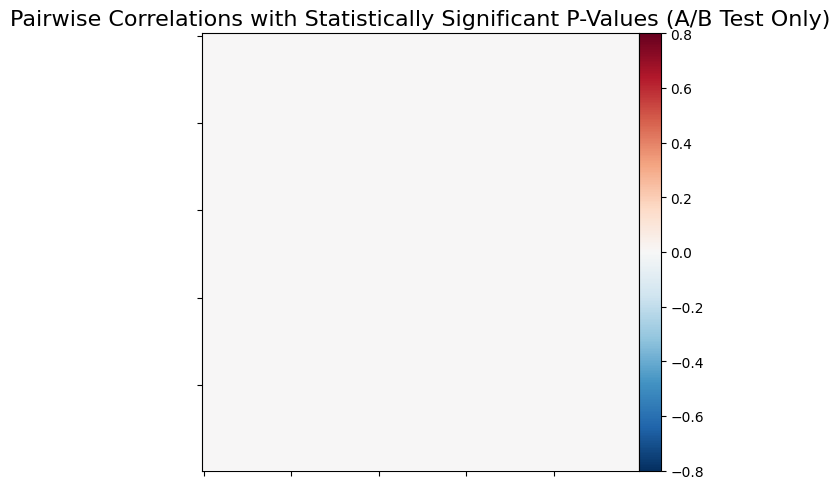

In [54]:
plotting.plot_matrix( 
    ab_sig_only_netmats, colorbar=True, vmax=0.8, vmin=-0.8, title = "Pairwise Correlations with Statistically Significant P-Values (A/B Test Only)")


Given how KNNs perform well on sparse datasets, the smaller subset of pairwise correlations yielded by the $t$-test may serve as a beneficial filter when generating our training data. We may want to consider overfitting, however.

## Step 3. Exploratory Values

Of all unique pairwise regions, what proportion of them have statistically significant differences in correlation between males and females?

In [40]:
1 - (get_upper_triangular(t_significant_regions) == 0).mean() # proportion of all pairwise regions that have statistically significant difference

0.3424242424242424

How much of the overall difference between males and females is attributable to the pairwise regions with statistically significant differences in correlation between males and females?

In [41]:
np.linalg.norm(t_significant_regions) / observed_overall_diff # proportion of the overall difference attributable to significant regions


0.9328249730217114

## Pairwise Regions with Statistically Significant Different Correlation Values Between Males and Females

In [42]:
def set_upper_triangular(symmetric_matrix):
    '''returns only the upper triangular values of a symmetric matrix'''
    num_pairwise = symmetric_matrix.shape[0]
    no_diagonal = 1

    new_matrix = symmetric_matrix.copy()
    new_matrix[np.tril_indices(n=num_pairwise, k=no_diagonal)] = 0
    return new_matrix

In [43]:
m_significant_regions = np.where(t_significant_regions == 0, 0, m_avg_netmat)
f_significant_regions = np.where(t_significant_regions == 0, 0, f_avg_netmat)

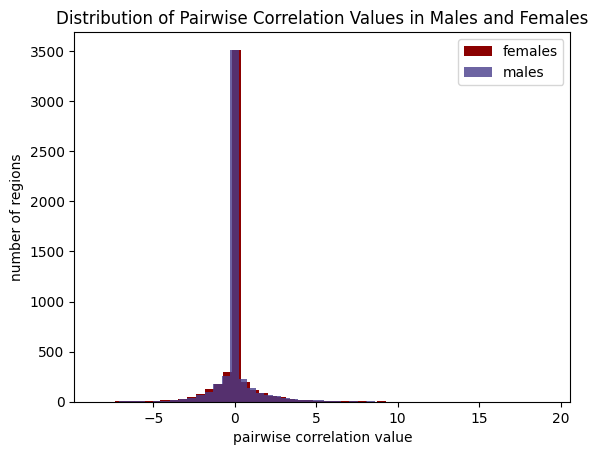

In [44]:
bins = 50
plt.hist(get_upper_triangular(f_significant_regions).flatten(), bins=bins, label="females", color="darkred")
plt.hist(get_upper_triangular(m_significant_regions).flatten(), bins=bins, label="males", alpha=0.8, color="darkslateblue")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Pairwise Correlation Values in Males and Females')
plt.legend()

plt.show()

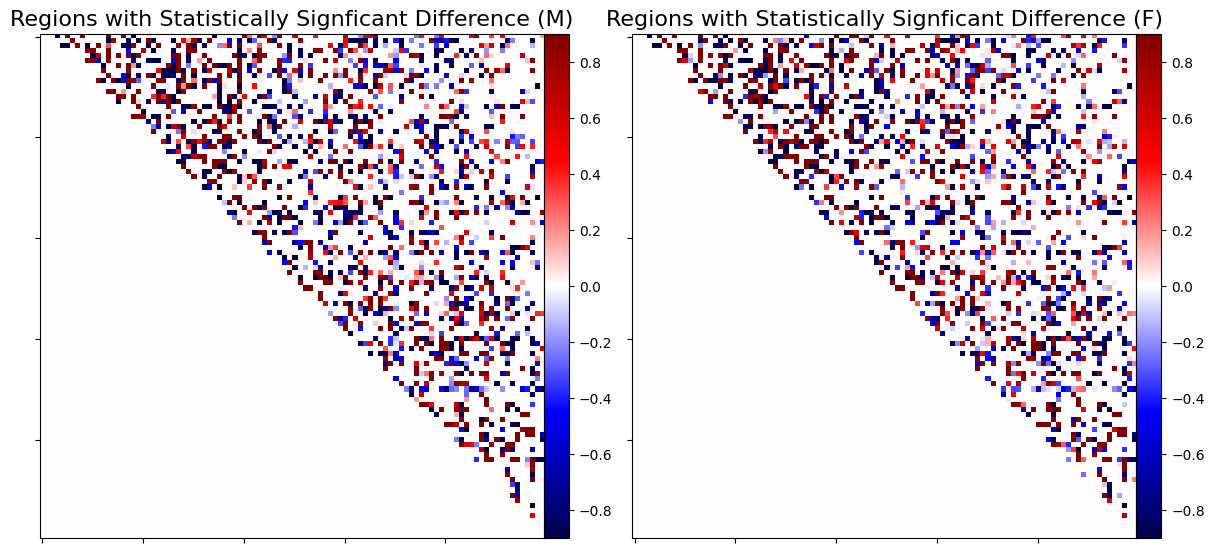

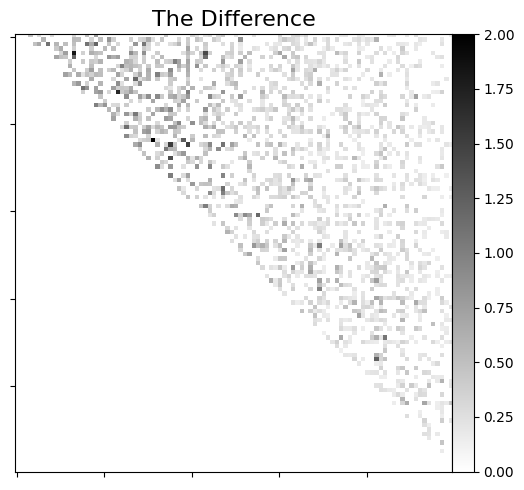

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(m_significant_regions), colorbar=True, vmax=0.9, vmin=-0.9, axes=axes[0], title = "Regions with Statistically Signficant Difference (M)", cmap='seismic')
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(f_significant_regions), colorbar=True, vmax=0.9, vmin=-0.9, axes=axes[1], title = "Regions with Statistically Signficant Difference (F)", cmap='seismic')
plotting.plot_matrix( # visualize element-wise difference of averages
    set_upper_triangular(np.abs(m_significant_regions - f_significant_regions)), colorbar=True, vmax=2, vmin=0, title = "The Difference", cmap='binary')

## Pairwise Regions with Lowest P-Value

In [46]:
lowest_t_pvals = np.isclose(t_p_vals, np.min(t_p_vals))
m_most_diff = set_upper_triangular(np.where(lowest_t_pvals, m_significant_regions, 0))
f_most_diff = set_upper_triangular(np.where(lowest_t_pvals, f_significant_regions, 0))

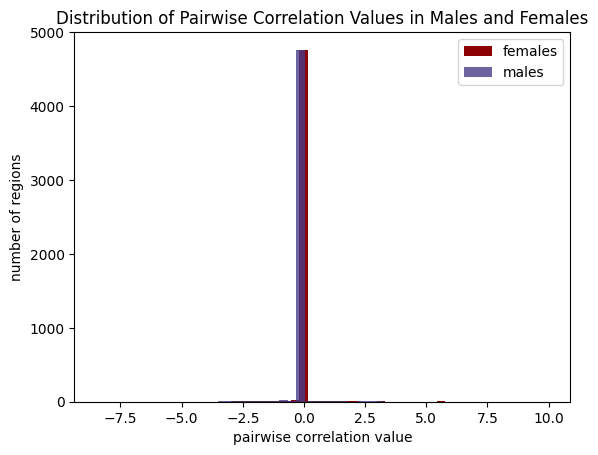

In [47]:
bins = 50
plt.hist(get_upper_triangular(m_most_diff).flatten(), bins=bins, label="females", color="darkred")
plt.hist(get_upper_triangular(f_most_diff).flatten(), bins=bins, label="males", alpha=0.8, color="darkslateblue")

plt.xlabel('pairwise correlation value')
plt.ylabel('number of regions')
plt.title('Distribution of Pairwise Correlation Values in Males and Females')
plt.legend()

plt.show()

In [48]:
(m_most_diff - f_most_diff).min()

-1.6780929470456711

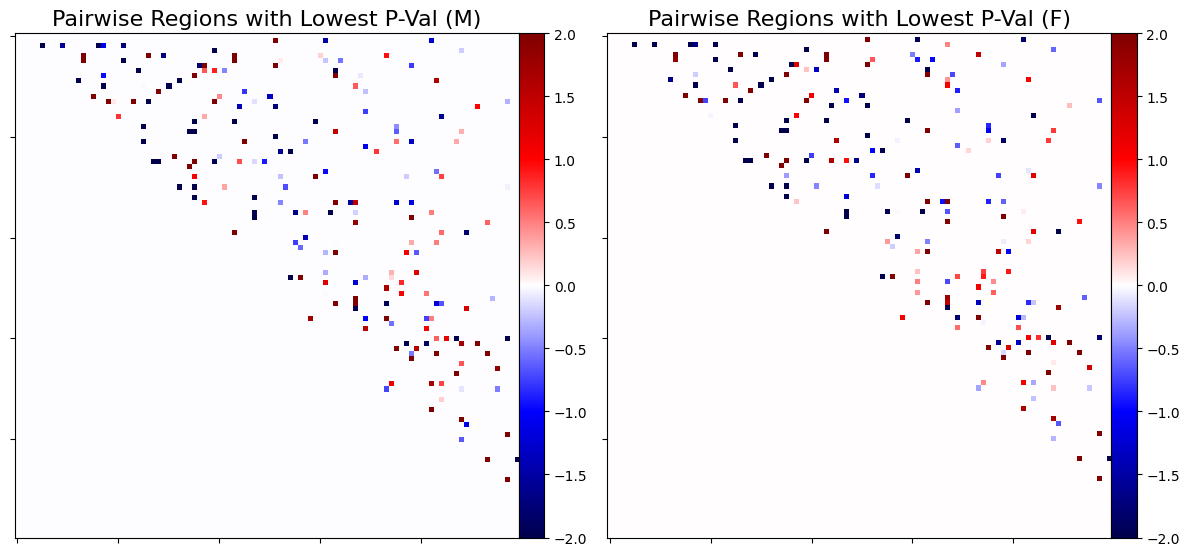

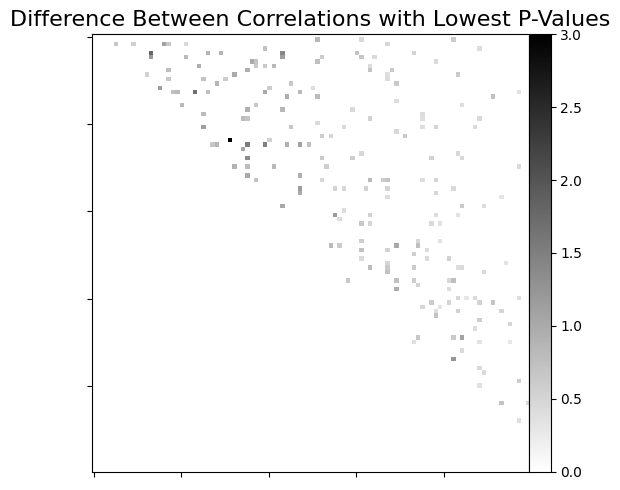

In [49]:
# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first matrix on the left
plotting.plot_matrix(m_most_diff, colorbar=True, vmax=2, vmin=-2, title="Pairwise Regions with Lowest P-Val (M)", axes=axes[0], cmap='seismic')

# Plot the second matrix on the right
plotting.plot_matrix(f_most_diff, colorbar=True, vmax=2, vmin=-2, title="Pairwise Regions with Lowest P-Val (F)", axes=axes[1], cmap='seismic')

plotting.plot_matrix( # visualize element-wise difference of averages
    np.abs(m_most_diff - f_most_diff), colorbar=True, vmax=3, vmin=0, title = "Difference Between Correlations with Lowest P-Values", cmap='binary')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()